# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



In [1]:
#%%capture
#from pyvirtualdisplay import Display
#virtual_display = Display(visible=0, size=(1400, 900))
#virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [2]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [3]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [4]:
class ActorCriticNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_network = nn.Sequential(
            nn.Linear(8, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh()
        )
        self.action_layer = nn.Linear(128, 4)
        self.critic_layer = nn.Linear(128, 1)
    
    def forward(self, state):
        shared_nw_output = self.shared_network(state)
        action_prob = F.softmax(self.action_layer(shared_nw_output), dim=-1)
        critic_score = self.critic_layer(shared_nw_output).squeeze(-1)
        return action_prob, critic_score
        

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [5]:
class ActorCriticAgent:
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-3)
    
    def forward(self, state):
        return self.network(state)
    
    def learn(self, log_probs, returns, critic_score, coef_value=1.0):
        advantage = (returns - critic_score).detach()
        
        action_loss = (-log_probs * advantage).sum()
        crtic_socre_loss = F.smooth_l1_loss(critic_score, returns, reduction="sum")
        loss = action_loss + coef_value * crtic_socre_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        state_t = torch.from_numpy(np.array(state)).float()
        action_prob, critic_score = self.network(state_t)
        dist = Categorical(action_prob)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, critic_score
    
        

Lastly, build a network and agent to start training.

In [6]:
network = ActorCriticNetwork()
agent = ActorCriticAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [7]:
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 16  # update the  agent every 5 episode
NUM_BATCH = 600        # totally update the agent for 500 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs_all, returns_all, values_all = [], [], []
    total_rewards, final_rewards = [], []
    
    for _ in range(EPISODE_PER_BATCH):
        state = env.reset()
        ep_log_probs, ep_rewards, ep_values = [], [], []
        total_reward = 0.0
        
        while True:
            action, log_prob, critic_score = agent.sample(state)
            next_state, reward, done, _ = env.step(action)
            
            ep_log_probs.append(log_prob)
            ep_rewards.append(float(reward))
            ep_values.append(critic_score)
            
            state = next_state
            total_reward += float(reward)
            
            if done:
                G = 0.0
                gamma = 0.99
                ep_returns = []
                for r in reversed(ep_rewards):
                    G = r + gamma * G
                    ep_returns.insert(0, G)
                
                log_probs_all.extend(ep_log_probs)
                returns_all.extend(ep_returns)
                values_all.extend(ep_values)
                
                final_rewards.append(ep_rewards[-1])
                total_rewards.append(total_reward)
                
                break
            
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(
        f"Total: {avg_total_reward: 6.1f}, Final: {avg_final_reward: 6.1f}"
    )
    print(
        f"epoch:{batch+1}:len(returns_all) = {len(returns_all)} || "
        f"avg_total_reward = {avg_total_reward:.2f} || avg_final_reward = {avg_final_reward:.2f}"
    )
    

    returns_t = torch.from_numpy(
        (
            (np.asarray(returns_all, dtype=np.float32) - np.mean(returns_all))
            / (np.std(returns_all) + 1e-9)
        ).astype(np.float32)
    )
    
    log_probs_t = torch.stack(log_probs_all)
    values_t = torch.stack(values_all).float().squeeze(-1)
   
    agent.learn(log_probs_t, returns_t, values_t)

  0%|          | 0/600 [00:00<?, ?it/s]

epoch:1:len(returns_all) = 1674 || avg_total_reward = -232.79 || avg_final_reward = -100.00


epoch:2:len(returns_all) = 1374 || avg_total_reward = -176.97 || avg_final_reward = -100.00


epoch:3:len(returns_all) = 1554 || avg_total_reward = -168.89 || avg_final_reward = -100.00


epoch:4:len(returns_all) = 1592 || avg_total_reward = -219.55 || avg_final_reward = -100.00


epoch:5:len(returns_all) = 1706 || avg_total_reward = -180.81 || avg_final_reward = -100.00


epoch:6:len(returns_all) = 1486 || avg_total_reward = -158.00 || avg_final_reward = -100.00


epoch:7:len(returns_all) = 1521 || avg_total_reward = -129.48 || avg_final_reward = -100.00


epoch:8:len(returns_all) = 1411 || avg_total_reward = -143.72 || avg_final_reward = -100.00


epoch:9:len(returns_all) = 1471 || avg_total_reward = -180.87 || avg_final_reward = -100.00


epoch:10:len(returns_all) = 1643 || avg_total_reward = -158.72 || avg_final_reward = -100.00


epoch:11:len(returns_all) = 1535 || avg_total_reward = -148.20 || avg_final_reward = -100.00


epoch:12:len(returns_all) = 1622 || avg_total_reward = -161.06 || avg_final_reward = -100.00


epoch:13:len(returns_all) = 1643 || avg_total_reward = -171.22 || avg_final_reward = -100.00


epoch:14:len(returns_all) = 1504 || avg_total_reward = -106.57 || avg_final_reward = -100.00


epoch:15:len(returns_all) = 1635 || avg_total_reward = -156.85 || avg_final_reward = -100.00


epoch:16:len(returns_all) = 1654 || avg_total_reward = -129.83 || avg_final_reward = -100.00


epoch:17:len(returns_all) = 1536 || avg_total_reward = -164.77 || avg_final_reward = -100.00


epoch:18:len(returns_all) = 1720 || avg_total_reward = -175.74 || avg_final_reward = -100.00


epoch:19:len(returns_all) = 1431 || avg_total_reward = -129.46 || avg_final_reward = -100.00


epoch:20:len(returns_all) = 1561 || avg_total_reward = -139.89 || avg_final_reward = -100.00


epoch:21:len(returns_all) = 1573 || avg_total_reward = -128.45 || avg_final_reward = -100.00


epoch:22:len(returns_all) = 1543 || avg_total_reward = -160.72 || avg_final_reward = -100.00


epoch:23:len(returns_all) = 1799 || avg_total_reward = -144.92 || avg_final_reward = -100.00


epoch:24:len(returns_all) = 1542 || avg_total_reward = -106.11 || avg_final_reward = -100.00


epoch:25:len(returns_all) = 1665 || avg_total_reward = -125.63 || avg_final_reward = -100.00


epoch:26:len(returns_all) = 1662 || avg_total_reward = -121.06 || avg_final_reward = -100.00


epoch:27:len(returns_all) = 1663 || avg_total_reward = -139.39 || avg_final_reward = -100.00


epoch:28:len(returns_all) = 1648 || avg_total_reward = -117.53 || avg_final_reward = -100.00


epoch:29:len(returns_all) = 1731 || avg_total_reward = -121.79 || avg_final_reward = -100.00


epoch:30:len(returns_all) = 1621 || avg_total_reward = -107.30 || avg_final_reward = -100.00


epoch:31:len(returns_all) = 1632 || avg_total_reward = -121.13 || avg_final_reward = -100.00


epoch:32:len(returns_all) = 1583 || avg_total_reward = -105.10 || avg_final_reward = -100.00


epoch:33:len(returns_all) = 2373 || avg_total_reward = -114.71 || avg_final_reward = -93.18


epoch:34:len(returns_all) = 1745 || avg_total_reward = -139.81 || avg_final_reward = -100.00


epoch:35:len(returns_all) = 1690 || avg_total_reward = -128.78 || avg_final_reward = -100.00


epoch:36:len(returns_all) = 1412 || avg_total_reward = -106.51 || avg_final_reward = -100.00


epoch:37:len(returns_all) = 1758 || avg_total_reward = -123.29 || avg_final_reward = -100.00


epoch:38:len(returns_all) = 1688 || avg_total_reward = -125.71 || avg_final_reward = -100.00


epoch:39:len(returns_all) = 1562 || avg_total_reward = -98.19 || avg_final_reward = -100.00


epoch:40:len(returns_all) = 1655 || avg_total_reward = -135.52 || avg_final_reward = -100.00


epoch:41:len(returns_all) = 1728 || avg_total_reward = -93.75 || avg_final_reward = -100.00


epoch:42:len(returns_all) = 1720 || avg_total_reward = -90.93 || avg_final_reward = -100.00


epoch:43:len(returns_all) = 1834 || avg_total_reward = -120.62 || avg_final_reward = -100.00


epoch:44:len(returns_all) = 1771 || avg_total_reward = -98.38 || avg_final_reward = -100.00


epoch:45:len(returns_all) = 1628 || avg_total_reward = -88.24 || avg_final_reward = -100.00


epoch:46:len(returns_all) = 1636 || avg_total_reward = -93.95 || avg_final_reward = -100.00


epoch:47:len(returns_all) = 1834 || avg_total_reward = -96.63 || avg_final_reward = -100.00


epoch:48:len(returns_all) = 1665 || avg_total_reward = -101.68 || avg_final_reward = -100.00


epoch:49:len(returns_all) = 1535 || avg_total_reward = -93.99 || avg_final_reward = -100.00


epoch:50:len(returns_all) = 2081 || avg_total_reward = -106.57 || avg_final_reward = -100.00


epoch:51:len(returns_all) = 1732 || avg_total_reward = -104.56 || avg_final_reward = -100.00


epoch:52:len(returns_all) = 1999 || avg_total_reward = -79.84 || avg_final_reward = -100.00


epoch:53:len(returns_all) = 1982 || avg_total_reward = -84.00 || avg_final_reward = -100.00


epoch:54:len(returns_all) = 1985 || avg_total_reward = -82.23 || avg_final_reward = -100.00


epoch:55:len(returns_all) = 2068 || avg_total_reward = -71.42 || avg_final_reward = -100.00


epoch:56:len(returns_all) = 2021 || avg_total_reward = -107.67 || avg_final_reward = -100.00


epoch:57:len(returns_all) = 2094 || avg_total_reward = -83.09 || avg_final_reward = -100.00


epoch:58:len(returns_all) = 3809 || avg_total_reward = -66.50 || avg_final_reward = -87.79


epoch:59:len(returns_all) = 1992 || avg_total_reward = -80.61 || avg_final_reward = -100.00


epoch:60:len(returns_all) = 2063 || avg_total_reward = -67.36 || avg_final_reward = -100.00


epoch:61:len(returns_all) = 2389 || avg_total_reward = -120.07 || avg_final_reward = -100.00


epoch:62:len(returns_all) = 2325 || avg_total_reward = -79.15 || avg_final_reward = -100.00


epoch:63:len(returns_all) = 2269 || avg_total_reward = -53.25 || avg_final_reward = -100.00


epoch:64:len(returns_all) = 2407 || avg_total_reward = -99.70 || avg_final_reward = -100.00


epoch:65:len(returns_all) = 2131 || avg_total_reward = -74.17 || avg_final_reward = -100.00


epoch:66:len(returns_all) = 2064 || avg_total_reward = -69.00 || avg_final_reward = -100.00


epoch:67:len(returns_all) = 2047 || avg_total_reward = -44.90 || avg_final_reward = -100.00


epoch:68:len(returns_all) = 2219 || avg_total_reward = -84.80 || avg_final_reward = -100.00


epoch:69:len(returns_all) = 2258 || avg_total_reward = -49.53 || avg_final_reward = -100.00


epoch:70:len(returns_all) = 3214 || avg_total_reward = -47.00 || avg_final_reward = -93.99


epoch:71:len(returns_all) = 3320 || avg_total_reward = -43.08 || avg_final_reward = -92.56


epoch:72:len(returns_all) = 2906 || avg_total_reward = -63.45 || avg_final_reward = -100.00


epoch:73:len(returns_all) = 2483 || avg_total_reward = -47.52 || avg_final_reward = -100.00


epoch:74:len(returns_all) = 2257 || avg_total_reward = -38.05 || avg_final_reward = -100.00


epoch:75:len(returns_all) = 3918 || avg_total_reward = -73.31 || avg_final_reward = -94.01


epoch:76:len(returns_all) = 3225 || avg_total_reward = -18.22 || avg_final_reward = -93.80


epoch:77:len(returns_all) = 3841 || avg_total_reward = -32.88 || avg_final_reward = -87.29


epoch:78:len(returns_all) = 2746 || avg_total_reward = -54.68 || avg_final_reward = -100.00


epoch:79:len(returns_all) = 3708 || avg_total_reward = -51.65 || avg_final_reward = -100.00


epoch:80:len(returns_all) = 4880 || avg_total_reward = -21.07 || avg_final_reward = -81.41


epoch:81:len(returns_all) = 3905 || avg_total_reward = -7.82 || avg_final_reward = -88.03


epoch:82:len(returns_all) = 3592 || avg_total_reward = -47.45 || avg_final_reward = -93.67


epoch:83:len(returns_all) = 3300 || avg_total_reward = -22.52 || avg_final_reward = -93.76


epoch:84:len(returns_all) = 2963 || avg_total_reward = -61.28 || avg_final_reward = -100.00


epoch:85:len(returns_all) = 3902 || avg_total_reward = -13.09 || avg_final_reward = -87.46


epoch:86:len(returns_all) = 2708 || avg_total_reward = -20.73 || avg_final_reward = -100.00


epoch:87:len(returns_all) = 4093 || avg_total_reward = -26.46 || avg_final_reward = -87.19


epoch:88:len(returns_all) = 2800 || avg_total_reward = -28.64 || avg_final_reward = -100.00


epoch:89:len(returns_all) = 6745 || avg_total_reward = -6.88 || avg_final_reward = -74.61


epoch:90:len(returns_all) = 5650 || avg_total_reward = -29.76 || avg_final_reward = -81.30


epoch:91:len(returns_all) = 5508 || avg_total_reward = -57.41 || avg_final_reward = -81.39


epoch:92:len(returns_all) = 4698 || avg_total_reward = -81.83 || avg_final_reward = -93.80


epoch:93:len(returns_all) = 8895 || avg_total_reward = -60.58 || avg_final_reward = -63.19


epoch:94:len(returns_all) = 6228 || avg_total_reward = -87.06 || avg_final_reward = -87.07


epoch:95:len(returns_all) = 7083 || avg_total_reward = -50.62 || avg_final_reward = -74.90


epoch:96:len(returns_all) = 5904 || avg_total_reward = -63.98 || avg_final_reward = -87.80


epoch:97:len(returns_all) = 6358 || avg_total_reward = -19.74 || avg_final_reward = -76.01


epoch:98:len(returns_all) = 7065 || avg_total_reward = -28.74 || avg_final_reward = -68.05


epoch:99:len(returns_all) = 6872 || avg_total_reward = -36.32 || avg_final_reward = -76.05


epoch:100:len(returns_all) = 6856 || avg_total_reward = -12.92 || avg_final_reward = -74.56


epoch:101:len(returns_all) = 7039 || avg_total_reward = -27.82 || avg_final_reward = -69.53


epoch:102:len(returns_all) = 4108 || avg_total_reward = 2.62 || avg_final_reward = -87.46


epoch:103:len(returns_all) = 2513 || avg_total_reward = -21.00 || avg_final_reward = -100.00


epoch:104:len(returns_all) = 3330 || avg_total_reward = -7.94 || avg_final_reward = -93.74


epoch:105:len(returns_all) = 3947 || avg_total_reward = -22.34 || avg_final_reward = -93.01


epoch:106:len(returns_all) = 4018 || avg_total_reward = -27.18 || avg_final_reward = -87.41


epoch:107:len(returns_all) = 3158 || avg_total_reward = -2.99 || avg_final_reward = -93.76


epoch:108:len(returns_all) = 3408 || avg_total_reward = 6.38 || avg_final_reward = -93.78


epoch:109:len(returns_all) = 4213 || avg_total_reward = 5.57 || avg_final_reward = -87.48


epoch:110:len(returns_all) = 4361 || avg_total_reward = 21.20 || avg_final_reward = -86.54


epoch:111:len(returns_all) = 3991 || avg_total_reward = 1.32 || avg_final_reward = -87.06


epoch:112:len(returns_all) = 5065 || avg_total_reward = 10.25 || avg_final_reward = -81.35


epoch:113:len(returns_all) = 5315 || avg_total_reward = -5.99 || avg_final_reward = -81.90


epoch:114:len(returns_all) = 4721 || avg_total_reward = 5.87 || avg_final_reward = -88.13


epoch:115:len(returns_all) = 7734 || avg_total_reward = 24.23 || avg_final_reward = -62.85


epoch:116:len(returns_all) = 4285 || avg_total_reward = 16.87 || avg_final_reward = -86.74


epoch:117:len(returns_all) = 4257 || avg_total_reward = 13.86 || avg_final_reward = -87.63


epoch:118:len(returns_all) = 5695 || avg_total_reward = 21.79 || avg_final_reward = -75.37


epoch:119:len(returns_all) = 5790 || avg_total_reward = 18.21 || avg_final_reward = -74.98


epoch:120:len(returns_all) = 5194 || avg_total_reward = 17.57 || avg_final_reward = -80.81


epoch:121:len(returns_all) = 8540 || avg_total_reward = 40.71 || avg_final_reward = -56.10


epoch:122:len(returns_all) = 7589 || avg_total_reward = 16.18 || avg_final_reward = -61.50


epoch:123:len(returns_all) = 5345 || avg_total_reward = 18.68 || avg_final_reward = -81.24


epoch:124:len(returns_all) = 12466 || avg_total_reward = 8.09 || avg_final_reward = -31.39


epoch:125:len(returns_all) = 5455 || avg_total_reward = 6.76 || avg_final_reward = -82.06


epoch:126:len(returns_all) = 9895 || avg_total_reward = 28.37 || avg_final_reward = -49.98


epoch:127:len(returns_all) = 8901 || avg_total_reward = -3.35 || avg_final_reward = -69.17


epoch:128:len(returns_all) = 9978 || avg_total_reward = 19.28 || avg_final_reward = -51.26


epoch:129:len(returns_all) = 10560 || avg_total_reward = 20.97 || avg_final_reward = -44.90


epoch:130:len(returns_all) = 6161 || avg_total_reward = 17.91 || avg_final_reward = -76.24


epoch:131:len(returns_all) = 10746 || avg_total_reward = 36.36 || avg_final_reward = -43.12


epoch:132:len(returns_all) = 7894 || avg_total_reward = 19.65 || avg_final_reward = -61.82


epoch:133:len(returns_all) = 5187 || avg_total_reward = 23.36 || avg_final_reward = -81.28


epoch:134:len(returns_all) = 11033 || avg_total_reward = 54.44 || avg_final_reward = -37.41


epoch:135:len(returns_all) = 3575 || avg_total_reward = 11.71 || avg_final_reward = -93.77


epoch:136:len(returns_all) = 4416 || avg_total_reward = 23.65 || avg_final_reward = -87.69


epoch:137:len(returns_all) = 5302 || avg_total_reward = 37.89 || avg_final_reward = -81.25


epoch:138:len(returns_all) = 5990 || avg_total_reward = 34.25 || avg_final_reward = -74.78


epoch:139:len(returns_all) = 4610 || avg_total_reward = 25.00 || avg_final_reward = -86.79


epoch:140:len(returns_all) = 5517 || avg_total_reward = 21.18 || avg_final_reward = -80.46


epoch:141:len(returns_all) = 7171 || avg_total_reward = 55.99 || avg_final_reward = -68.99


epoch:142:len(returns_all) = 6336 || avg_total_reward = 48.32 || avg_final_reward = -75.44


epoch:143:len(returns_all) = 6338 || avg_total_reward = 44.67 || avg_final_reward = -75.10


epoch:144:len(returns_all) = 7992 || avg_total_reward = 35.98 || avg_final_reward = -62.48


epoch:145:len(returns_all) = 6979 || avg_total_reward = 40.51 || avg_final_reward = -68.26


epoch:146:len(returns_all) = 8057 || avg_total_reward = 56.71 || avg_final_reward = -62.56


epoch:147:len(returns_all) = 10308 || avg_total_reward = 80.63 || avg_final_reward = -37.24


epoch:148:len(returns_all) = 7071 || avg_total_reward = 45.55 || avg_final_reward = -67.46


epoch:149:len(returns_all) = 10607 || avg_total_reward = 60.08 || avg_final_reward = -43.19


epoch:150:len(returns_all) = 7165 || avg_total_reward = 40.17 || avg_final_reward = -68.19


epoch:151:len(returns_all) = 11893 || avg_total_reward = 77.69 || avg_final_reward = -31.32


epoch:152:len(returns_all) = 8547 || avg_total_reward = 61.33 || avg_final_reward = -56.32


epoch:153:len(returns_all) = 7627 || avg_total_reward = 38.05 || avg_final_reward = -62.55


epoch:154:len(returns_all) = 11944 || avg_total_reward = 101.31 || avg_final_reward = -25.17


epoch:155:len(returns_all) = 10935 || avg_total_reward = 70.55 || avg_final_reward = -37.78


epoch:156:len(returns_all) = 10091 || avg_total_reward = 63.22 || avg_final_reward = -42.91


epoch:157:len(returns_all) = 12230 || avg_total_reward = 67.07 || avg_final_reward = -37.42


epoch:158:len(returns_all) = 12658 || avg_total_reward = 90.46 || avg_final_reward = -24.98


epoch:159:len(returns_all) = 12781 || avg_total_reward = 87.06 || avg_final_reward = -25.87


epoch:160:len(returns_all) = 10233 || avg_total_reward = 63.74 || avg_final_reward = -43.66


epoch:161:len(returns_all) = 10069 || avg_total_reward = 62.27 || avg_final_reward = -43.11


epoch:162:len(returns_all) = 9698 || avg_total_reward = 49.26 || avg_final_reward = -50.13


epoch:163:len(returns_all) = 12633 || avg_total_reward = 85.32 || avg_final_reward = -25.76


epoch:164:len(returns_all) = 9825 || avg_total_reward = 69.65 || avg_final_reward = -43.75


epoch:165:len(returns_all) = 13113 || avg_total_reward = 118.79 || avg_final_reward = -12.32


epoch:166:len(returns_all) = 11270 || avg_total_reward = 44.62 || avg_final_reward = -36.72


epoch:167:len(returns_all) = 4579 || avg_total_reward = 34.48 || avg_final_reward = -87.64


epoch:168:len(returns_all) = 10985 || avg_total_reward = 100.65 || avg_final_reward = -24.58


epoch:169:len(returns_all) = 11839 || avg_total_reward = 97.60 || avg_final_reward = -31.67


epoch:170:len(returns_all) = 8584 || avg_total_reward = 69.36 || avg_final_reward = -55.61


epoch:171:len(returns_all) = 12849 || avg_total_reward = 96.70 || avg_final_reward = -25.74


epoch:172:len(returns_all) = 10155 || avg_total_reward = 65.85 || avg_final_reward = -43.70


epoch:173:len(returns_all) = 13459 || avg_total_reward = 109.43 || avg_final_reward = -11.89


epoch:174:len(returns_all) = 12521 || avg_total_reward = 61.72 || avg_final_reward = -31.97


epoch:175:len(returns_all) = 12745 || avg_total_reward = 73.13 || avg_final_reward = -24.08


epoch:176:len(returns_all) = 15281 || avg_total_reward = 97.61 || avg_final_reward = -6.33


epoch:177:len(returns_all) = 15105 || avg_total_reward = 93.05 || avg_final_reward = -1.18


epoch:178:len(returns_all) = 13002 || avg_total_reward = 91.98 || avg_final_reward = -24.50


epoch:179:len(returns_all) = 14545 || avg_total_reward = 85.98 || avg_final_reward = -12.52


epoch:180:len(returns_all) = 14460 || avg_total_reward = 101.93 || avg_final_reward = -12.46


epoch:181:len(returns_all) = 13050 || avg_total_reward = 84.38 || avg_final_reward = -25.24


epoch:182:len(returns_all) = 13132 || avg_total_reward = 95.99 || avg_final_reward = -25.10


epoch:183:len(returns_all) = 13107 || avg_total_reward = 134.22 || avg_final_reward = 0.60


epoch:184:len(returns_all) = 12125 || avg_total_reward = 93.65 || avg_final_reward = -31.77


epoch:185:len(returns_all) = 12138 || avg_total_reward = 100.12 || avg_final_reward = -31.25


epoch:186:len(returns_all) = 13582 || avg_total_reward = 87.18 || avg_final_reward = -19.29


epoch:187:len(returns_all) = 11835 || avg_total_reward = 55.40 || avg_final_reward = -31.99


epoch:188:len(returns_all) = 12760 || avg_total_reward = 89.01 || avg_final_reward = -24.20


epoch:189:len(returns_all) = 10260 || avg_total_reward = 85.26 || avg_final_reward = -43.14


epoch:190:len(returns_all) = 8646 || avg_total_reward = 85.45 || avg_final_reward = -56.07


epoch:191:len(returns_all) = 13638 || avg_total_reward = 108.29 || avg_final_reward = -12.59


epoch:192:len(returns_all) = 9348 || avg_total_reward = 82.27 || avg_final_reward = -49.51


epoch:193:len(returns_all) = 12727 || avg_total_reward = 101.56 || avg_final_reward = -25.74


epoch:194:len(returns_all) = 8460 || avg_total_reward = 56.11 || avg_final_reward = -56.34


epoch:195:len(returns_all) = 12671 || avg_total_reward = 126.15 || avg_final_reward = -24.90


epoch:196:len(returns_all) = 12806 || avg_total_reward = 114.96 || avg_final_reward = -25.07


epoch:197:len(returns_all) = 11856 || avg_total_reward = 96.02 || avg_final_reward = -24.91


epoch:198:len(returns_all) = 14345 || avg_total_reward = 116.93 || avg_final_reward = -12.64


epoch:199:len(returns_all) = 13993 || avg_total_reward = 133.96 || avg_final_reward = -6.31


epoch:200:len(returns_all) = 15278 || avg_total_reward = 120.45 || avg_final_reward = -6.25


epoch:201:len(returns_all) = 14474 || avg_total_reward = 120.62 || avg_final_reward = -12.54


epoch:202:len(returns_all) = 13025 || avg_total_reward = 107.39 || avg_final_reward = -24.83


epoch:203:len(returns_all) = 15245 || avg_total_reward = 110.36 || avg_final_reward = -6.21


epoch:204:len(returns_all) = 15293 || avg_total_reward = 134.91 || avg_final_reward = -6.14


epoch:205:len(returns_all) = 14770 || avg_total_reward = 109.36 || avg_final_reward = -12.44


epoch:206:len(returns_all) = 15813 || avg_total_reward = 114.67 || avg_final_reward = -5.56


epoch:207:len(returns_all) = 15213 || avg_total_reward = 127.86 || avg_final_reward = -6.13


epoch:208:len(returns_all) = 15215 || avg_total_reward = 125.77 || avg_final_reward = -6.27


epoch:209:len(returns_all) = 12296 || avg_total_reward = 97.75 || avg_final_reward = -31.45


epoch:210:len(returns_all) = 15202 || avg_total_reward = 146.92 || avg_final_reward = -6.26


epoch:211:len(returns_all) = 11940 || avg_total_reward = 103.00 || avg_final_reward = -31.27


epoch:212:len(returns_all) = 14326 || avg_total_reward = 135.33 || avg_final_reward = -12.62


epoch:213:len(returns_all) = 13684 || avg_total_reward = 123.29 || avg_final_reward = -18.71


epoch:214:len(returns_all) = 14317 || avg_total_reward = 150.47 || avg_final_reward = -6.38


epoch:215:len(returns_all) = 10501 || avg_total_reward = 103.10 || avg_final_reward = -24.87


epoch:216:len(returns_all) = 10317 || avg_total_reward = 103.80 || avg_final_reward = -43.83


epoch:217:len(returns_all) = 12678 || avg_total_reward = 125.51 || avg_final_reward = -25.01


epoch:218:len(returns_all) = 14306 || avg_total_reward = 145.28 || avg_final_reward = -12.55


epoch:219:len(returns_all) = 12556 || avg_total_reward = 123.71 || avg_final_reward = -18.76


epoch:220:len(returns_all) = 12525 || avg_total_reward = 119.49 || avg_final_reward = -25.01


epoch:221:len(returns_all) = 14954 || avg_total_reward = 146.73 || avg_final_reward = -0.05


epoch:222:len(returns_all) = 12659 || avg_total_reward = 122.51 || avg_final_reward = -25.00


epoch:223:len(returns_all) = 10093 || avg_total_reward = 103.80 || avg_final_reward = -43.80


epoch:224:len(returns_all) = 15248 || avg_total_reward = 142.95 || avg_final_reward = -6.31


epoch:225:len(returns_all) = 14326 || avg_total_reward = 129.07 || avg_final_reward = -12.53


epoch:226:len(returns_all) = 13721 || avg_total_reward = 125.77 || avg_final_reward = -18.74


epoch:227:len(returns_all) = 12042 || avg_total_reward = 116.62 || avg_final_reward = -18.84


epoch:228:len(returns_all) = 12655 || avg_total_reward = 134.64 || avg_final_reward = -6.22


epoch:229:len(returns_all) = 12003 || avg_total_reward = 112.92 || avg_final_reward = -31.21


epoch:230:len(returns_all) = 13540 || avg_total_reward = 139.65 || avg_final_reward = -18.84


epoch:231:len(returns_all) = 12319 || avg_total_reward = 140.15 || avg_final_reward = -6.29


epoch:232:len(returns_all) = 13595 || avg_total_reward = 119.77 || avg_final_reward = -18.75


epoch:233:len(returns_all) = 15232 || avg_total_reward = 148.64 || avg_final_reward = -6.30


epoch:234:len(returns_all) = 14324 || avg_total_reward = 143.95 || avg_final_reward = -12.44


epoch:235:len(returns_all) = 12600 || avg_total_reward = 114.04 || avg_final_reward = -18.01


epoch:236:len(returns_all) = 10089 || avg_total_reward = 92.12 || avg_final_reward = -25.01


epoch:237:len(returns_all) = 13166 || avg_total_reward = 128.60 || avg_final_reward = -12.56


epoch:238:len(returns_all) = 12654 || avg_total_reward = 112.83 || avg_final_reward = -24.94


epoch:239:len(returns_all) = 13306 || avg_total_reward = 118.40 || avg_final_reward = -12.74


epoch:240:len(returns_all) = 9098 || avg_total_reward = 91.40 || avg_final_reward = -37.46


epoch:241:len(returns_all) = 11145 || avg_total_reward = 115.91 || avg_final_reward = -25.04


epoch:242:len(returns_all) = 13073 || avg_total_reward = 120.81 || avg_final_reward = -12.53


epoch:243:len(returns_all) = 11746 || avg_total_reward = 118.36 || avg_final_reward = -31.24


epoch:244:len(returns_all) = 10870 || avg_total_reward = 127.22 || avg_final_reward = -12.45


epoch:245:len(returns_all) = 13026 || avg_total_reward = 135.88 || avg_final_reward = -12.52


epoch:246:len(returns_all) = 12514 || avg_total_reward = 147.85 || avg_final_reward = 6.27


epoch:247:len(returns_all) = 11098 || avg_total_reward = 138.51 || avg_final_reward = 0.07


epoch:248:len(returns_all) = 10989 || avg_total_reward = 161.78 || avg_final_reward = 6.29


epoch:249:len(returns_all) = 8590 || avg_total_reward = 159.50 || avg_final_reward = 12.52


epoch:250:len(returns_all) = 9539 || avg_total_reward = 208.61 || avg_final_reward = 56.27


epoch:251:len(returns_all) = 6104 || avg_total_reward = 136.05 || avg_final_reward = -0.00


epoch:252:len(returns_all) = 5285 || avg_total_reward = 169.62 || avg_final_reward = 18.75


epoch:253:len(returns_all) = 6054 || avg_total_reward = 247.27 || avg_final_reward = 81.25


epoch:254:len(returns_all) = 5337 || avg_total_reward = 188.56 || avg_final_reward = 37.50


epoch:255:len(returns_all) = 3628 || avg_total_reward = 169.71 || avg_final_reward = 25.00


epoch:256:len(returns_all) = 3337 || avg_total_reward = 76.25 || avg_final_reward = -56.26


epoch:257:len(returns_all) = 3070 || avg_total_reward = 74.84 || avg_final_reward = -62.50


epoch:258:len(returns_all) = 3205 || avg_total_reward = 163.99 || avg_final_reward = 12.50


epoch:259:len(returns_all) = 3113 || avg_total_reward = 138.51 || avg_final_reward = 0.00


epoch:260:len(returns_all) = 2736 || avg_total_reward = 68.56 || avg_final_reward = -50.00


epoch:261:len(returns_all) = 3572 || avg_total_reward = 90.13 || avg_final_reward = -37.50


epoch:262:len(returns_all) = 2045 || avg_total_reward = 68.35 || avg_final_reward = -62.50


epoch:263:len(returns_all) = 2483 || avg_total_reward = 56.40 || avg_final_reward = -62.50


epoch:264:len(returns_all) = 2330 || avg_total_reward = 40.94 || avg_final_reward = -75.00


epoch:265:len(returns_all) = 2371 || avg_total_reward = 69.41 || avg_final_reward = -50.00


epoch:266:len(returns_all) = 2047 || avg_total_reward = 53.43 || avg_final_reward = -75.00


epoch:267:len(returns_all) = 2193 || avg_total_reward = 34.89 || avg_final_reward = -75.00


epoch:268:len(returns_all) = 2363 || avg_total_reward = 67.65 || avg_final_reward = -62.50


epoch:269:len(returns_all) = 1862 || avg_total_reward = 14.19 || avg_final_reward = -100.00


epoch:270:len(returns_all) = 2055 || avg_total_reward = 37.84 || avg_final_reward = -75.00


epoch:271:len(returns_all) = 2166 || avg_total_reward = 36.79 || avg_final_reward = -62.50


epoch:272:len(returns_all) = 2426 || avg_total_reward = 65.34 || avg_final_reward = -50.00


epoch:273:len(returns_all) = 2741 || avg_total_reward = 73.23 || avg_final_reward = -37.50


epoch:274:len(returns_all) = 2304 || avg_total_reward = 27.04 || avg_final_reward = -62.50


epoch:275:len(returns_all) = 2517 || avg_total_reward = 82.91 || avg_final_reward = -37.50


epoch:276:len(returns_all) = 2616 || avg_total_reward = 145.10 || avg_final_reward = 12.50


epoch:277:len(returns_all) = 2613 || avg_total_reward = 82.08 || avg_final_reward = -50.00


epoch:278:len(returns_all) = 3103 || avg_total_reward = 94.72 || avg_final_reward = -25.00


epoch:279:len(returns_all) = 2300 || avg_total_reward = 59.78 || avg_final_reward = -62.50


epoch:280:len(returns_all) = 2606 || avg_total_reward = 84.74 || avg_final_reward = -37.50


epoch:281:len(returns_all) = 4909 || avg_total_reward = 166.75 || avg_final_reward = 37.50


epoch:282:len(returns_all) = 2957 || avg_total_reward = 99.07 || avg_final_reward = -25.00


epoch:283:len(returns_all) = 3888 || avg_total_reward = 160.41 || avg_final_reward = 25.00


epoch:284:len(returns_all) = 3425 || avg_total_reward = 103.61 || avg_final_reward = -25.00


epoch:285:len(returns_all) = 3686 || avg_total_reward = 175.48 || avg_final_reward = 25.00


epoch:286:len(returns_all) = 5310 || avg_total_reward = 125.46 || avg_final_reward = 6.71


epoch:287:len(returns_all) = 4218 || avg_total_reward = 79.14 || avg_final_reward = -12.50


epoch:288:len(returns_all) = 2855 || avg_total_reward = 101.91 || avg_final_reward = -25.00


epoch:289:len(returns_all) = 3665 || avg_total_reward = 141.19 || avg_final_reward = 12.50


epoch:290:len(returns_all) = 3419 || avg_total_reward = 120.68 || avg_final_reward = 0.00


epoch:291:len(returns_all) = 3225 || avg_total_reward = 94.94 || avg_final_reward = -25.00


epoch:292:len(returns_all) = 3082 || avg_total_reward = 125.41 || avg_final_reward = 0.00


epoch:293:len(returns_all) = 3432 || avg_total_reward = 183.35 || avg_final_reward = 37.50


epoch:294:len(returns_all) = 4191 || avg_total_reward = 54.15 || avg_final_reward = -37.50


epoch:295:len(returns_all) = 2922 || avg_total_reward = 109.78 || avg_final_reward = -25.00


epoch:296:len(returns_all) = 3388 || avg_total_reward = 114.25 || avg_final_reward = -12.50


epoch:297:len(returns_all) = 3639 || avg_total_reward = 153.56 || avg_final_reward = 25.00


epoch:298:len(returns_all) = 4616 || avg_total_reward = 136.98 || avg_final_reward = 7.46


epoch:299:len(returns_all) = 3344 || avg_total_reward = 139.41 || avg_final_reward = 12.50


epoch:300:len(returns_all) = 4254 || avg_total_reward = 173.72 || avg_final_reward = 37.50


epoch:301:len(returns_all) = 4293 || avg_total_reward = 207.04 || avg_final_reward = 56.40


epoch:302:len(returns_all) = 3500 || avg_total_reward = 157.88 || avg_final_reward = 12.50


epoch:303:len(returns_all) = 4154 || avg_total_reward = 159.87 || avg_final_reward = 25.00


epoch:304:len(returns_all) = 4360 || avg_total_reward = 87.02 || avg_final_reward = -18.83


epoch:305:len(returns_all) = 3981 || avg_total_reward = 135.07 || avg_final_reward = 12.50


epoch:306:len(returns_all) = 4856 || avg_total_reward = 185.49 || avg_final_reward = 56.23


epoch:307:len(returns_all) = 4599 || avg_total_reward = 190.47 || avg_final_reward = 43.74


epoch:308:len(returns_all) = 3295 || avg_total_reward = 159.63 || avg_final_reward = 25.00


epoch:309:len(returns_all) = 4761 || avg_total_reward = 169.91 || avg_final_reward = 31.12


epoch:310:len(returns_all) = 4819 || avg_total_reward = 196.28 || avg_final_reward = 43.75


epoch:311:len(returns_all) = 3604 || avg_total_reward = 171.91 || avg_final_reward = 25.00


epoch:312:len(returns_all) = 4067 || avg_total_reward = 142.11 || avg_final_reward = 12.50


epoch:313:len(returns_all) = 3791 || avg_total_reward = 207.88 || avg_final_reward = 62.50


epoch:314:len(returns_all) = 3480 || avg_total_reward = 121.42 || avg_final_reward = 12.50


epoch:315:len(returns_all) = 3463 || avg_total_reward = 163.01 || avg_final_reward = 25.00


epoch:316:len(returns_all) = 4529 || avg_total_reward = 194.74 || avg_final_reward = 50.00


epoch:317:len(returns_all) = 3355 || avg_total_reward = 191.81 || avg_final_reward = 50.00


epoch:318:len(returns_all) = 4225 || avg_total_reward = 120.15 || avg_final_reward = 6.27


epoch:319:len(returns_all) = 4705 || avg_total_reward = 166.88 || avg_final_reward = 42.35


epoch:320:len(returns_all) = 3603 || avg_total_reward = 152.37 || avg_final_reward = 25.00


epoch:321:len(returns_all) = 4531 || avg_total_reward = 178.46 || avg_final_reward = 43.75


epoch:322:len(returns_all) = 5022 || avg_total_reward = 210.27 || avg_final_reward = 62.50


epoch:323:len(returns_all) = 4748 || avg_total_reward = 141.38 || avg_final_reward = 18.87


epoch:324:len(returns_all) = 3241 || avg_total_reward = 129.72 || avg_final_reward = 12.50


epoch:325:len(returns_all) = 4161 || avg_total_reward = 247.97 || avg_final_reward = 87.50


epoch:326:len(returns_all) = 5257 || avg_total_reward = 233.03 || avg_final_reward = 81.25


epoch:327:len(returns_all) = 4456 || avg_total_reward = 183.72 || avg_final_reward = 50.00


epoch:328:len(returns_all) = 4126 || avg_total_reward = 199.37 || avg_final_reward = 62.50


epoch:329:len(returns_all) = 3406 || avg_total_reward = 186.72 || avg_final_reward = 37.50


epoch:330:len(returns_all) = 3648 || avg_total_reward = 200.73 || avg_final_reward = 50.00


epoch:331:len(returns_all) = 4408 || avg_total_reward = 163.87 || avg_final_reward = 43.72


epoch:332:len(returns_all) = 4223 || avg_total_reward = 158.76 || avg_final_reward = 25.00


epoch:333:len(returns_all) = 4242 || avg_total_reward = 201.53 || avg_final_reward = 62.50


epoch:334:len(returns_all) = 3544 || avg_total_reward = 176.43 || avg_final_reward = 37.50


epoch:335:len(returns_all) = 4736 || avg_total_reward = 200.08 || avg_final_reward = 62.50


epoch:336:len(returns_all) = 3999 || avg_total_reward = 213.80 || avg_final_reward = 62.50


epoch:337:len(returns_all) = 3748 || avg_total_reward = 182.30 || avg_final_reward = 37.50


epoch:338:len(returns_all) = 3549 || avg_total_reward = 184.04 || avg_final_reward = 37.50


epoch:339:len(returns_all) = 4963 || avg_total_reward = 182.96 || avg_final_reward = 56.27


epoch:340:len(returns_all) = 4103 || avg_total_reward = 182.99 || avg_final_reward = 50.00


epoch:341:len(returns_all) = 4869 || avg_total_reward = 172.40 || avg_final_reward = 43.77


epoch:342:len(returns_all) = 4029 || avg_total_reward = 216.82 || avg_final_reward = 62.50


epoch:343:len(returns_all) = 4553 || avg_total_reward = 172.72 || avg_final_reward = 43.68


epoch:344:len(returns_all) = 3499 || avg_total_reward = 202.97 || avg_final_reward = 50.00


epoch:345:len(returns_all) = 4249 || avg_total_reward = 201.29 || avg_final_reward = 62.50


epoch:346:len(returns_all) = 4284 || avg_total_reward = 235.58 || avg_final_reward = 87.50


epoch:347:len(returns_all) = 3959 || avg_total_reward = 247.38 || avg_final_reward = 75.00


epoch:348:len(returns_all) = 4857 || avg_total_reward = 214.06 || avg_final_reward = 75.00


epoch:349:len(returns_all) = 3670 || avg_total_reward = 218.30 || avg_final_reward = 62.50


epoch:350:len(returns_all) = 3750 || avg_total_reward = 189.79 || avg_final_reward = 50.00


epoch:351:len(returns_all) = 4330 || avg_total_reward = 222.25 || avg_final_reward = 75.00


epoch:352:len(returns_all) = 4020 || avg_total_reward = 240.31 || avg_final_reward = 87.50


epoch:353:len(returns_all) = 4091 || avg_total_reward = 218.69 || avg_final_reward = 62.50


epoch:354:len(returns_all) = 4263 || avg_total_reward = 194.82 || avg_final_reward = 50.00


epoch:355:len(returns_all) = 3552 || avg_total_reward = 194.42 || avg_final_reward = 50.00


epoch:356:len(returns_all) = 4124 || avg_total_reward = 216.61 || avg_final_reward = 75.00


epoch:357:len(returns_all) = 4076 || avg_total_reward = 220.01 || avg_final_reward = 62.50


epoch:358:len(returns_all) = 4886 || avg_total_reward = 206.85 || avg_final_reward = 62.50


epoch:359:len(returns_all) = 4928 || avg_total_reward = 183.40 || avg_final_reward = 56.27


epoch:360:len(returns_all) = 4327 || avg_total_reward = 193.01 || avg_final_reward = 56.32


epoch:361:len(returns_all) = 4052 || avg_total_reward = 227.36 || avg_final_reward = 75.00


epoch:362:len(returns_all) = 3656 || avg_total_reward = 223.06 || avg_final_reward = 62.50


epoch:363:len(returns_all) = 3790 || avg_total_reward = 203.69 || avg_final_reward = 62.50


epoch:364:len(returns_all) = 3974 || avg_total_reward = 183.71 || avg_final_reward = 37.50


epoch:365:len(returns_all) = 4752 || avg_total_reward = 203.04 || avg_final_reward = 62.50


epoch:366:len(returns_all) = 3043 || avg_total_reward = 130.29 || avg_final_reward = 0.00


epoch:367:len(returns_all) = 3798 || avg_total_reward = 170.48 || avg_final_reward = 37.50


epoch:368:len(returns_all) = 3146 || avg_total_reward = 154.93 || avg_final_reward = 25.00


epoch:369:len(returns_all) = 3000 || avg_total_reward = 114.73 || avg_final_reward = -12.50


epoch:370:len(returns_all) = 4264 || avg_total_reward = 206.48 || avg_final_reward = 50.00


epoch:371:len(returns_all) = 3449 || avg_total_reward = 118.85 || avg_final_reward = 0.00


epoch:372:len(returns_all) = 3148 || avg_total_reward = 172.88 || avg_final_reward = 25.00


epoch:373:len(returns_all) = 3719 || avg_total_reward = 182.64 || avg_final_reward = 37.50


epoch:374:len(returns_all) = 3907 || avg_total_reward = 141.23 || avg_final_reward = 25.00


epoch:375:len(returns_all) = 3638 || avg_total_reward = 226.45 || avg_final_reward = 75.00


epoch:376:len(returns_all) = 3160 || avg_total_reward = 180.45 || avg_final_reward = 37.50


epoch:377:len(returns_all) = 3469 || avg_total_reward = 162.91 || avg_final_reward = 25.00


epoch:378:len(returns_all) = 4186 || avg_total_reward = 200.03 || avg_final_reward = 62.50


epoch:379:len(returns_all) = 4156 || avg_total_reward = 157.95 || avg_final_reward = 31.14


epoch:380:len(returns_all) = 3514 || avg_total_reward = 183.48 || avg_final_reward = 37.50


epoch:381:len(returns_all) = 3257 || avg_total_reward = 209.13 || avg_final_reward = 50.00


epoch:382:len(returns_all) = 3363 || avg_total_reward = 184.34 || avg_final_reward = 37.50


epoch:383:len(returns_all) = 3380 || avg_total_reward = 206.82 || avg_final_reward = 50.00


epoch:384:len(returns_all) = 3924 || avg_total_reward = 214.96 || avg_final_reward = 62.50


epoch:385:len(returns_all) = 4749 || avg_total_reward = 230.36 || avg_final_reward = 75.00


epoch:386:len(returns_all) = 4439 || avg_total_reward = 225.20 || avg_final_reward = 75.00


epoch:387:len(returns_all) = 4069 || avg_total_reward = 251.20 || avg_final_reward = 87.50


epoch:388:len(returns_all) = 3262 || avg_total_reward = 148.46 || avg_final_reward = 12.50


epoch:389:len(returns_all) = 5403 || avg_total_reward = 223.85 || avg_final_reward = 87.50


epoch:390:len(returns_all) = 3988 || avg_total_reward = 234.05 || avg_final_reward = 87.50


epoch:391:len(returns_all) = 4722 || avg_total_reward = 202.00 || avg_final_reward = 62.50


epoch:392:len(returns_all) = 4307 || avg_total_reward = 170.83 || avg_final_reward = 25.00


epoch:393:len(returns_all) = 3905 || avg_total_reward = 220.80 || avg_final_reward = 62.50


epoch:394:len(returns_all) = 4057 || avg_total_reward = 147.44 || avg_final_reward = 25.00


epoch:395:len(returns_all) = 4515 || avg_total_reward = 214.54 || avg_final_reward = 62.50


epoch:396:len(returns_all) = 5826 || avg_total_reward = 181.90 || avg_final_reward = 50.07


epoch:397:len(returns_all) = 3952 || avg_total_reward = 196.33 || avg_final_reward = 50.00


epoch:398:len(returns_all) = 3608 || avg_total_reward = 215.13 || avg_final_reward = 62.50


epoch:399:len(returns_all) = 4036 || avg_total_reward = 244.94 || avg_final_reward = 87.50


epoch:400:len(returns_all) = 4146 || avg_total_reward = 235.47 || avg_final_reward = 87.50


epoch:401:len(returns_all) = 4068 || avg_total_reward = 216.89 || avg_final_reward = 62.50


epoch:402:len(returns_all) = 3667 || avg_total_reward = 239.51 || avg_final_reward = 75.00


epoch:403:len(returns_all) = 3267 || avg_total_reward = 205.01 || avg_final_reward = 50.00


epoch:404:len(returns_all) = 3448 || avg_total_reward = 220.35 || avg_final_reward = 62.50


epoch:405:len(returns_all) = 3092 || avg_total_reward = 180.18 || avg_final_reward = 25.00


epoch:406:len(returns_all) = 3292 || avg_total_reward = 208.72 || avg_final_reward = 50.00


epoch:407:len(returns_all) = 3789 || avg_total_reward = 203.84 || avg_final_reward = 50.00


epoch:408:len(returns_all) = 3562 || avg_total_reward = 233.34 || avg_final_reward = 75.00


epoch:409:len(returns_all) = 3765 || avg_total_reward = 218.37 || avg_final_reward = 62.50


epoch:410:len(returns_all) = 3144 || avg_total_reward = 203.22 || avg_final_reward = 50.00


epoch:411:len(returns_all) = 3707 || avg_total_reward = 207.27 || avg_final_reward = 62.50


epoch:412:len(returns_all) = 3470 || avg_total_reward = 220.81 || avg_final_reward = 62.50


epoch:413:len(returns_all) = 3893 || avg_total_reward = 260.06 || avg_final_reward = 87.50


epoch:414:len(returns_all) = 3903 || avg_total_reward = 210.85 || avg_final_reward = 62.50


epoch:415:len(returns_all) = 3592 || avg_total_reward = 234.46 || avg_final_reward = 75.00


epoch:416:len(returns_all) = 3080 || avg_total_reward = 172.28 || avg_final_reward = 37.50


epoch:417:len(returns_all) = 3780 || avg_total_reward = 167.86 || avg_final_reward = 25.00


epoch:418:len(returns_all) = 3988 || avg_total_reward = 203.73 || avg_final_reward = 50.00


epoch:419:len(returns_all) = 4344 || avg_total_reward = 223.96 || avg_final_reward = 75.00


epoch:420:len(returns_all) = 4039 || avg_total_reward = 223.75 || avg_final_reward = 75.00


epoch:421:len(returns_all) = 3616 || avg_total_reward = 165.60 || avg_final_reward = 37.50


epoch:422:len(returns_all) = 3609 || avg_total_reward = 256.80 || avg_final_reward = 87.50


epoch:423:len(returns_all) = 3634 || avg_total_reward = 214.29 || avg_final_reward = 50.00


epoch:424:len(returns_all) = 3745 || avg_total_reward = 222.68 || avg_final_reward = 62.50


epoch:425:len(returns_all) = 4443 || avg_total_reward = 241.17 || avg_final_reward = 87.50


epoch:426:len(returns_all) = 4380 || avg_total_reward = 256.39 || avg_final_reward = 87.50


epoch:427:len(returns_all) = 4335 || avg_total_reward = 230.66 || avg_final_reward = 75.00


epoch:428:len(returns_all) = 3911 || avg_total_reward = 188.20 || avg_final_reward = 37.50


epoch:429:len(returns_all) = 3846 || avg_total_reward = 244.13 || avg_final_reward = 87.50


epoch:430:len(returns_all) = 3464 || avg_total_reward = 186.02 || avg_final_reward = 37.50


epoch:431:len(returns_all) = 3218 || avg_total_reward = 200.67 || avg_final_reward = 37.50


epoch:432:len(returns_all) = 3899 || avg_total_reward = 223.09 || avg_final_reward = 75.00


epoch:433:len(returns_all) = 4067 || avg_total_reward = 267.48 || avg_final_reward = 100.00


epoch:434:len(returns_all) = 3436 || avg_total_reward = 230.33 || avg_final_reward = 75.00


epoch:435:len(returns_all) = 3911 || avg_total_reward = 221.19 || avg_final_reward = 75.00


epoch:436:len(returns_all) = 3742 || avg_total_reward = 190.38 || avg_final_reward = 37.50


epoch:437:len(returns_all) = 4380 || avg_total_reward = 258.09 || avg_final_reward = 100.00


epoch:438:len(returns_all) = 3740 || avg_total_reward = 193.78 || avg_final_reward = 37.50


epoch:439:len(returns_all) = 3731 || avg_total_reward = 205.18 || avg_final_reward = 50.00


epoch:440:len(returns_all) = 4232 || avg_total_reward = 224.74 || avg_final_reward = 75.00


epoch:441:len(returns_all) = 4603 || avg_total_reward = 218.81 || avg_final_reward = 75.00


epoch:442:len(returns_all) = 4234 || avg_total_reward = 226.41 || avg_final_reward = 75.00


epoch:443:len(returns_all) = 4122 || avg_total_reward = 221.12 || avg_final_reward = 75.00


epoch:444:len(returns_all) = 4297 || avg_total_reward = 219.04 || avg_final_reward = 62.50


epoch:445:len(returns_all) = 4256 || avg_total_reward = 222.71 || avg_final_reward = 75.00


epoch:446:len(returns_all) = 3966 || avg_total_reward = 258.24 || avg_final_reward = 87.50


epoch:447:len(returns_all) = 4032 || avg_total_reward = 212.93 || avg_final_reward = 62.50


epoch:448:len(returns_all) = 5799 || avg_total_reward = 183.64 || avg_final_reward = 49.94


epoch:449:len(returns_all) = 4450 || avg_total_reward = 214.30 || avg_final_reward = 75.00


epoch:450:len(returns_all) = 4441 || avg_total_reward = 209.63 || avg_final_reward = 62.50


epoch:451:len(returns_all) = 4332 || avg_total_reward = 199.67 || avg_final_reward = 50.00


epoch:452:len(returns_all) = 3997 || avg_total_reward = 251.63 || avg_final_reward = 87.50


epoch:453:len(returns_all) = 3772 || avg_total_reward = 215.15 || avg_final_reward = 62.50


epoch:454:len(returns_all) = 3870 || avg_total_reward = 233.26 || avg_final_reward = 75.00


epoch:455:len(returns_all) = 4101 || avg_total_reward = 230.43 || avg_final_reward = 75.00


epoch:456:len(returns_all) = 3306 || avg_total_reward = 199.01 || avg_final_reward = 50.00


epoch:457:len(returns_all) = 3270 || avg_total_reward = 205.48 || avg_final_reward = 50.00


epoch:458:len(returns_all) = 3316 || avg_total_reward = 213.90 || avg_final_reward = 62.50


epoch:459:len(returns_all) = 3722 || avg_total_reward = 209.93 || avg_final_reward = 62.50


epoch:460:len(returns_all) = 3265 || avg_total_reward = 222.34 || avg_final_reward = 62.50


epoch:461:len(returns_all) = 3214 || avg_total_reward = 219.24 || avg_final_reward = 62.50


epoch:462:len(returns_all) = 2932 || avg_total_reward = 197.15 || avg_final_reward = 37.50


epoch:463:len(returns_all) = 3729 || avg_total_reward = 203.59 || avg_final_reward = 50.00


epoch:464:len(returns_all) = 3720 || avg_total_reward = 221.55 || avg_final_reward = 62.50


epoch:465:len(returns_all) = 3132 || avg_total_reward = 202.47 || avg_final_reward = 50.00


epoch:466:len(returns_all) = 3569 || avg_total_reward = 252.46 || avg_final_reward = 87.50


epoch:467:len(returns_all) = 3930 || avg_total_reward = 262.15 || avg_final_reward = 100.00


epoch:468:len(returns_all) = 4251 || avg_total_reward = 213.65 || avg_final_reward = 62.50


epoch:469:len(returns_all) = 3494 || avg_total_reward = 203.15 || avg_final_reward = 50.00


epoch:470:len(returns_all) = 2902 || avg_total_reward = 172.50 || avg_final_reward = 37.50


epoch:471:len(returns_all) = 3768 || avg_total_reward = 246.37 || avg_final_reward = 87.50


epoch:472:len(returns_all) = 3055 || avg_total_reward = 183.32 || avg_final_reward = 25.00


epoch:473:len(returns_all) = 3207 || avg_total_reward = 191.79 || avg_final_reward = 37.50


epoch:474:len(returns_all) = 3311 || avg_total_reward = 201.22 || avg_final_reward = 50.00


epoch:475:len(returns_all) = 3390 || avg_total_reward = 186.67 || avg_final_reward = 37.50


epoch:476:len(returns_all) = 3401 || avg_total_reward = 216.23 || avg_final_reward = 62.50


epoch:477:len(returns_all) = 3412 || avg_total_reward = 229.29 || avg_final_reward = 62.50


epoch:478:len(returns_all) = 4267 || avg_total_reward = 266.59 || avg_final_reward = 100.00


epoch:479:len(returns_all) = 3353 || avg_total_reward = 219.26 || avg_final_reward = 62.50


epoch:480:len(returns_all) = 4116 || avg_total_reward = 230.57 || avg_final_reward = 75.00


epoch:481:len(returns_all) = 4489 || avg_total_reward = 218.43 || avg_final_reward = 62.50


epoch:482:len(returns_all) = 3540 || avg_total_reward = 231.70 || avg_final_reward = 75.00


epoch:483:len(returns_all) = 3215 || avg_total_reward = 209.10 || avg_final_reward = 50.00


epoch:484:len(returns_all) = 3974 || avg_total_reward = 194.87 || avg_final_reward = 50.00


epoch:485:len(returns_all) = 3687 || avg_total_reward = 229.33 || avg_final_reward = 75.00


epoch:486:len(returns_all) = 4199 || avg_total_reward = 221.12 || avg_final_reward = 75.00


epoch:487:len(returns_all) = 3235 || avg_total_reward = 182.24 || avg_final_reward = 25.00


epoch:488:len(returns_all) = 3680 || avg_total_reward = 244.51 || avg_final_reward = 87.50


epoch:489:len(returns_all) = 4514 || avg_total_reward = 231.22 || avg_final_reward = 75.00


epoch:490:len(returns_all) = 3667 || avg_total_reward = 209.00 || avg_final_reward = 50.00


epoch:491:len(returns_all) = 4545 || avg_total_reward = 197.51 || avg_final_reward = 62.50


epoch:492:len(returns_all) = 3870 || avg_total_reward = 207.81 || avg_final_reward = 62.50


epoch:493:len(returns_all) = 4115 || avg_total_reward = 235.15 || avg_final_reward = 81.24


epoch:494:len(returns_all) = 3325 || avg_total_reward = 214.56 || avg_final_reward = 50.00


epoch:495:len(returns_all) = 4256 || avg_total_reward = 244.45 || avg_final_reward = 81.24


epoch:496:len(returns_all) = 3650 || avg_total_reward = 212.14 || avg_final_reward = 50.00


epoch:497:len(returns_all) = 3658 || avg_total_reward = 242.21 || avg_final_reward = 75.00


epoch:498:len(returns_all) = 3305 || avg_total_reward = 216.28 || avg_final_reward = 50.00


epoch:499:len(returns_all) = 3616 || avg_total_reward = 240.24 || avg_final_reward = 75.00


epoch:500:len(returns_all) = 3310 || avg_total_reward = 235.24 || avg_final_reward = 75.00


epoch:501:len(returns_all) = 3856 || avg_total_reward = 236.18 || avg_final_reward = 75.00


epoch:502:len(returns_all) = 3025 || avg_total_reward = 192.74 || avg_final_reward = 37.50


epoch:503:len(returns_all) = 3790 || avg_total_reward = 229.28 || avg_final_reward = 75.00


epoch:504:len(returns_all) = 3827 || avg_total_reward = 234.99 || avg_final_reward = 75.00


epoch:505:len(returns_all) = 4425 || avg_total_reward = 229.83 || avg_final_reward = 75.00


epoch:506:len(returns_all) = 3302 || avg_total_reward = 257.54 || avg_final_reward = 87.50


epoch:507:len(returns_all) = 3504 || avg_total_reward = 202.55 || avg_final_reward = 37.50


epoch:508:len(returns_all) = 3435 || avg_total_reward = 199.07 || avg_final_reward = 50.00


epoch:509:len(returns_all) = 3179 || avg_total_reward = 241.05 || avg_final_reward = 75.00


epoch:510:len(returns_all) = 3479 || avg_total_reward = 242.70 || avg_final_reward = 75.00


epoch:511:len(returns_all) = 3465 || avg_total_reward = 210.81 || avg_final_reward = 50.00


epoch:512:len(returns_all) = 3443 || avg_total_reward = 210.61 || avg_final_reward = 50.00


epoch:513:len(returns_all) = 3638 || avg_total_reward = 148.07 || avg_final_reward = 25.00


epoch:514:len(returns_all) = 2895 || avg_total_reward = 154.32 || avg_final_reward = 12.50


epoch:515:len(returns_all) = 4751 || avg_total_reward = 216.90 || avg_final_reward = 56.18


epoch:516:len(returns_all) = 3653 || avg_total_reward = 249.78 || avg_final_reward = 87.50


epoch:517:len(returns_all) = 3501 || avg_total_reward = 239.93 || avg_final_reward = 75.00


epoch:518:len(returns_all) = 3675 || avg_total_reward = 222.01 || avg_final_reward = 62.50


epoch:519:len(returns_all) = 3697 || avg_total_reward = 237.46 || avg_final_reward = 75.00


epoch:520:len(returns_all) = 3461 || avg_total_reward = 219.01 || avg_final_reward = 62.50


epoch:521:len(returns_all) = 3800 || avg_total_reward = 267.40 || avg_final_reward = 100.00


epoch:522:len(returns_all) = 3899 || avg_total_reward = 249.89 || avg_final_reward = 87.50


epoch:523:len(returns_all) = 3833 || avg_total_reward = 265.93 || avg_final_reward = 87.50


epoch:524:len(returns_all) = 5296 || avg_total_reward = 216.96 || avg_final_reward = 68.75


epoch:525:len(returns_all) = 3272 || avg_total_reward = 220.79 || avg_final_reward = 62.50


epoch:526:len(returns_all) = 4004 || avg_total_reward = 210.82 || avg_final_reward = 62.50


epoch:527:len(returns_all) = 3621 || avg_total_reward = 207.68 || avg_final_reward = 50.00


epoch:528:len(returns_all) = 4640 || avg_total_reward = 235.74 || avg_final_reward = 87.50


epoch:529:len(returns_all) = 3761 || avg_total_reward = 237.57 || avg_final_reward = 75.00


epoch:530:len(returns_all) = 3622 || avg_total_reward = 253.55 || avg_final_reward = 87.50


epoch:531:len(returns_all) = 3931 || avg_total_reward = 256.51 || avg_final_reward = 87.50


epoch:532:len(returns_all) = 3644 || avg_total_reward = 273.70 || avg_final_reward = 100.00


epoch:533:len(returns_all) = 3509 || avg_total_reward = 256.69 || avg_final_reward = 87.50


epoch:534:len(returns_all) = 3892 || avg_total_reward = 249.08 || avg_final_reward = 87.50


epoch:535:len(returns_all) = 4427 || avg_total_reward = 203.39 || avg_final_reward = 62.50


epoch:536:len(returns_all) = 4057 || avg_total_reward = 227.82 || avg_final_reward = 75.00


epoch:537:len(returns_all) = 3952 || avg_total_reward = 208.76 || avg_final_reward = 62.50


epoch:538:len(returns_all) = 4286 || avg_total_reward = 252.39 || avg_final_reward = 100.00


epoch:539:len(returns_all) = 4121 || avg_total_reward = 251.42 || avg_final_reward = 87.50


epoch:540:len(returns_all) = 3739 || avg_total_reward = 248.02 || avg_final_reward = 87.50


epoch:541:len(returns_all) = 4072 || avg_total_reward = 243.33 || avg_final_reward = 87.50


epoch:542:len(returns_all) = 4815 || avg_total_reward = 262.03 || avg_final_reward = 93.75


epoch:543:len(returns_all) = 3893 || avg_total_reward = 256.36 || avg_final_reward = 87.50


epoch:544:len(returns_all) = 3256 || avg_total_reward = 212.77 || avg_final_reward = 50.00


epoch:545:len(returns_all) = 4134 || avg_total_reward = 202.86 || avg_final_reward = 50.00


epoch:546:len(returns_all) = 3847 || avg_total_reward = 260.61 || avg_final_reward = 100.00


epoch:547:len(returns_all) = 4006 || avg_total_reward = 257.18 || avg_final_reward = 87.50


epoch:548:len(returns_all) = 3235 || avg_total_reward = 202.23 || avg_final_reward = 50.00


epoch:549:len(returns_all) = 3476 || avg_total_reward = 225.94 || avg_final_reward = 62.50


epoch:550:len(returns_all) = 3262 || avg_total_reward = 239.30 || avg_final_reward = 75.00


epoch:551:len(returns_all) = 3174 || avg_total_reward = 236.32 || avg_final_reward = 62.50


epoch:552:len(returns_all) = 3040 || avg_total_reward = 214.23 || avg_final_reward = 50.00


epoch:553:len(returns_all) = 3692 || avg_total_reward = 240.49 || avg_final_reward = 75.00


epoch:554:len(returns_all) = 3210 || avg_total_reward = 227.58 || avg_final_reward = 62.50


epoch:555:len(returns_all) = 3875 || avg_total_reward = 201.97 || avg_final_reward = 50.00


epoch:556:len(returns_all) = 3752 || avg_total_reward = 230.73 || avg_final_reward = 62.50


epoch:557:len(returns_all) = 3068 || avg_total_reward = 221.68 || avg_final_reward = 50.00


epoch:558:len(returns_all) = 3429 || avg_total_reward = 227.57 || avg_final_reward = 62.50


epoch:559:len(returns_all) = 3569 || avg_total_reward = 197.95 || avg_final_reward = 37.50


epoch:560:len(returns_all) = 3244 || avg_total_reward = 249.12 || avg_final_reward = 75.00


epoch:561:len(returns_all) = 3875 || avg_total_reward = 207.77 || avg_final_reward = 43.75


epoch:562:len(returns_all) = 3332 || avg_total_reward = 208.12 || avg_final_reward = 50.00


epoch:563:len(returns_all) = 2971 || avg_total_reward = 207.24 || avg_final_reward = 50.00


epoch:564:len(returns_all) = 2777 || avg_total_reward = 197.97 || avg_final_reward = 37.50


epoch:565:len(returns_all) = 3372 || avg_total_reward = 239.79 || avg_final_reward = 62.50


epoch:566:len(returns_all) = 3207 || avg_total_reward = 226.48 || avg_final_reward = 50.00


epoch:567:len(returns_all) = 4362 || avg_total_reward = 254.34 || avg_final_reward = 87.50


epoch:568:len(returns_all) = 3490 || avg_total_reward = 228.51 || avg_final_reward = 62.50


epoch:569:len(returns_all) = 4033 || avg_total_reward = 266.58 || avg_final_reward = 100.00


epoch:570:len(returns_all) = 3377 || avg_total_reward = 243.05 || avg_final_reward = 75.00


epoch:571:len(returns_all) = 3324 || avg_total_reward = 274.05 || avg_final_reward = 87.50


epoch:572:len(returns_all) = 4148 || avg_total_reward = 206.44 || avg_final_reward = 50.00


epoch:573:len(returns_all) = 3660 || avg_total_reward = 263.22 || avg_final_reward = 87.50


epoch:574:len(returns_all) = 4387 || avg_total_reward = 213.45 || avg_final_reward = 62.50


epoch:575:len(returns_all) = 3644 || avg_total_reward = 242.76 || avg_final_reward = 75.00


epoch:576:len(returns_all) = 4359 || avg_total_reward = 227.01 || avg_final_reward = 75.00


epoch:577:len(returns_all) = 3720 || avg_total_reward = 250.17 || avg_final_reward = 75.00


epoch:578:len(returns_all) = 4405 || avg_total_reward = 233.70 || avg_final_reward = 68.71


epoch:579:len(returns_all) = 4087 || avg_total_reward = 232.97 || avg_final_reward = 75.00


epoch:580:len(returns_all) = 4135 || avg_total_reward = 242.02 || avg_final_reward = 87.50


epoch:581:len(returns_all) = 3888 || avg_total_reward = 274.31 || avg_final_reward = 100.00


epoch:582:len(returns_all) = 3935 || avg_total_reward = 247.72 || avg_final_reward = 87.50


epoch:583:len(returns_all) = 4018 || avg_total_reward = 275.29 || avg_final_reward = 100.00


epoch:584:len(returns_all) = 3640 || avg_total_reward = 235.38 || avg_final_reward = 75.00


epoch:585:len(returns_all) = 4010 || avg_total_reward = 236.53 || avg_final_reward = 75.00


epoch:586:len(returns_all) = 3925 || avg_total_reward = 236.20 || avg_final_reward = 75.00


epoch:587:len(returns_all) = 3654 || avg_total_reward = 197.98 || avg_final_reward = 37.50


epoch:588:len(returns_all) = 4576 || avg_total_reward = 250.36 || avg_final_reward = 87.50


epoch:589:len(returns_all) = 3419 || avg_total_reward = 190.99 || avg_final_reward = 37.50


epoch:590:len(returns_all) = 4050 || avg_total_reward = 236.53 || avg_final_reward = 75.00


epoch:591:len(returns_all) = 3479 || avg_total_reward = 217.54 || avg_final_reward = 62.50


epoch:592:len(returns_all) = 4129 || avg_total_reward = 252.80 || avg_final_reward = 87.50


epoch:593:len(returns_all) = 4123 || avg_total_reward = 256.26 || avg_final_reward = 87.50


epoch:594:len(returns_all) = 3682 || avg_total_reward = 276.27 || avg_final_reward = 100.00


epoch:595:len(returns_all) = 4393 || avg_total_reward = 240.70 || avg_final_reward = 87.50


epoch:596:len(returns_all) = 3771 || avg_total_reward = 275.93 || avg_final_reward = 100.00


epoch:597:len(returns_all) = 3795 || avg_total_reward = 261.44 || avg_final_reward = 87.50


epoch:598:len(returns_all) = 3609 || avg_total_reward = 245.39 || avg_final_reward = 75.00


epoch:599:len(returns_all) = 4237 || avg_total_reward = 265.12 || avg_final_reward = 100.00


epoch:600:len(returns_all) = 3364 || avg_total_reward = 219.25 || avg_final_reward = 50.00


### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


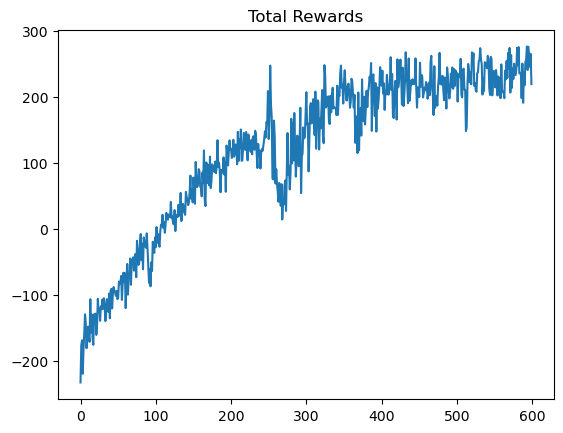

In [8]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


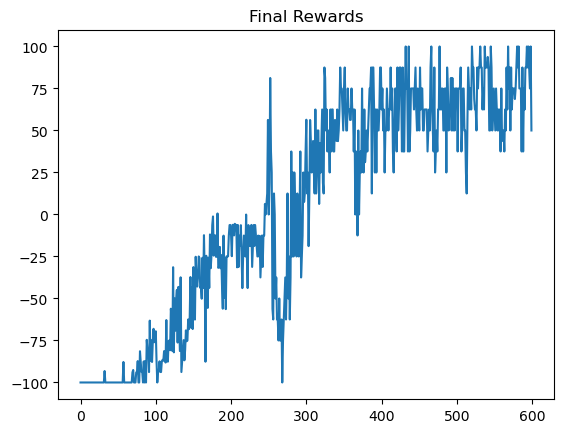

In [9]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

268.81054534706345


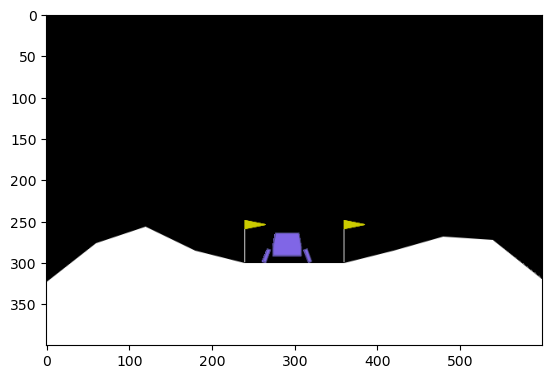

In [10]:
fix(env, seed)
agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)

  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing


In [11]:
print(np.mean(test_total_reward))

288.87617704274015


Action list

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
